In [1]:
import os
import shutil#
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import time
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 3942, done.
remote: Counting objects: 100% (978/978), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 3942 (delta 184), reused 242 (delta 154), pack-reused 2964
Receiving objects: 100% (3942/3942), 36.81 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (1129/1129), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 7.5 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 149 kB 55.2 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 15.7 MB 238 kB/s 
     |████████████████████████████████| 308 kB 51.3 MB/s 
     |████████████████████████████████| 112 kB 60.6 MB/s 
     |████████████████████████████████| 2.1 MB 51.8 MB/s 
     |████████████████████████████████| 596 kB 12.4 MB/s 
     |██████████████████████████████

10
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
190
0.12375296834959724
259
0.4054648962016587
260
0.2657581424344487
148
0.06527284643891335
248
0.3525694712942495
267
0.0692525186197931
150
0.04951612381989362
190
0.18426759180418095
147
0.08177990579532357
267
0.09877369110064858
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 10
new dataset length: 100
created union_x attr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/loc

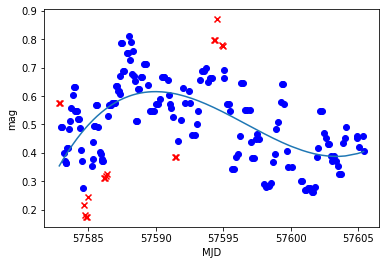

In [2]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')

# hypers: 
Edelson = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_graham(plot=True, index=0,std_threshold=1) \
            .resample_dataset(num_samples=9) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.33)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

# plt.scatter(Edelson.dataset[1,:-100,0], Edelson.dataset[1,:-100,1])
# Edelson.union_x.shape

In [3]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

agn_df = pd.read_csv('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)
# lcs[0] = lcs[0][lcs[0][:,0].argsort()]
# lcs[0] = np.concatenate((lcs[0][:10], lcs[0][410:]))
lcs = [lcs[0]]

# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part

AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_outliers() \
                      .resample_dataset(num_samples=5) \
                      .normalize(normalize_y='individual', normalize_x='individual', x_by_range=True, y_by_range=False) \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .make_masks(frac=0.5) \
                      .set_target_x()


print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


# fig,ax = plt.subplots(5,1, figsize=(20,20))
# for i in range(5):
#     ax[i].scatter(AGN_1H2106.dataset[i,:-50,0], AGN_1H2106.dataset[i,:-50,1])

indexes of outliers to be pruned, if any: [600 601]
generating 5 new sample of each example in the dataset & appending them 
 old dataset length: 1
new dataset length: 6
created union_x attribute of length 619
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (6, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(619,) (6, 619, 3) (6, 619) (6, 619)


In [4]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.3, 
                 elbo_weight=1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=2., net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.33, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=64)



In [5]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
LightCurves = AGN_1H2106.dataset
#np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Catalina.dataset, Catalina.subsampled_mask[:,:,np.newaxis], Catalina.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

print(LightCurves.shape)


(6, 619, 3)


In [7]:
training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [8]:
net = models.load_network(args, DIM, torch.Tensor(AGN_1H2106.union_x))
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.002057519)

In [9]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.00257519

0.002057519


In [13]:
AGN_1H2106.set_target_x(num_points=200)
recons = []

In [ ]:
start = time.time()
end_times = []
nlls = []
mses = []
epochs = []
for epoch in range(1, 1001): #args.niters + 1):
    if epoch == 1:
        reconstruction, qz_mean, qz_std = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0], net, num_points=200, device=device, k_iwae=50)
        recons.append(reconstruction)
    nll, mse = my_utils.train(net, optimizer, epoch, train_loader, args)
    if epoch % 10 == 0:
        epochs.append(epoch)
        nlls.append(nll)
        mses.append(mse)
        end = time.time()
        end_times.append(end)
        reconstruction, qz_mean, qz_std = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0], net, num_points=200, device=device, k_iwae=50)
        recons.append(reconstruction)

Iter: 100, train loss: 1.9373, avg nll: 1.0339, avg kl: 0.1098, mse: 0.446213, mae: 0.534818
Iter: 200, train loss: 1.5524, avg nll: 0.7566, avg kl: 0.0908, mse: 0.393347, mae: 0.464672
Iter: 300, train loss: 1.4190, avg nll: 0.7011, avg kl: 0.0577, mse: 0.356074, mae: 0.445800
Iter: 400, train loss: 1.3663, avg nll: 0.6938, avg kl: 0.0667, mse: 0.332886, mae: 0.414571
Iter: 500, train loss: 0.9006, avg nll: 0.5013, avg kl: 0.0539, mse: 0.196946, mae: 0.323128


In [18]:
AGN_1H2106.error_to_sample_weight()
AGN_1H2106.dataset[0,:10,2]

array([0.09511895, 0.09511895, 0.07350101, 0.08647177, 0.0778246 ,
       0.06917742, 0.07350101, 0.07350101, 0.07350101, 0.06917742],
      dtype=float32)

In [27]:
elapsed = [f'{round((end - start),3)}' for end in end_times]
mses = [round(float(mse), 3) for mse in mses]
nlls = [round(float(nll), 3) for nll in nlls]
elapsed.insert(0,'0')
print(elapsed, mses, nlls)

['0', '0.602', '1.188', '1.789', '2.378', '2.963', '3.546', '4.136', '4.724', '5.307', '5.891', '6.477', '7.061', '7.645', '8.229', '8.813', '9.399', '9.983', '10.57', '11.154', '11.74', '12.328', '12.91', '13.494', '14.08', '14.67', '15.253', '15.837', '16.423', '17.008', '17.591', '18.177', '18.762', '19.349', '19.935', '20.533', '21.141', '21.751', '22.349', '22.931', '23.516', '24.102', '24.685', '25.268', '25.854', '26.44', '27.026', '27.614', '28.198', '28.784', '29.368', '29.954', '30.541', '31.123', '31.71', '32.293', '32.88', '33.463', '34.046', '34.629', '35.215', '35.8', '36.384', '36.969', '37.552', '38.136', '38.722', '39.305', '39.888', '40.47', '41.056', '41.644', '42.229', '42.813', '43.397', '43.981', '44.566', '45.154', '45.737', '46.32', '46.907', '47.494', '48.078', '48.662', '49.246', '49.832', '50.416', '51.002', '51.586', '52.173', '52.758', '53.344', '53.929', '54.514', '55.098', '55.682', '56.268', '56.855', '57.438', '58.023', '58.61'] [0.121, 0.117, 0.117, 0.

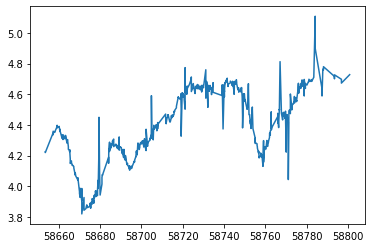

In [28]:
# denormalize reconstructions and the example we're going to animate

i = 0
xmean, xstd = AGN_1H2106.x_mean_std[i]
ymean, ystd = AGN_1H2106.y_mean_std[i]

denorm_recons = []

for recon in recons:
    denorm_recon = recon.copy()
    denorm_recon[:,0] = (denorm_recon[:,0] * xstd) + xmean
    denorm_recon[:,1] = (denorm_recon[:,1] * ystd) + ymean
    denorm_recon[:,2] = denorm_recon[:,2] * ystd
    denorm_recons.append(denorm_recon)


ex= AGN_1H2106.dataset[i].copy()

ex[:,0] = (ex[:,0] * xstd) + xmean
ex[:,1] = (ex[:,1]) * ystd + ymean
ex[:,2] = ex[:,2] * ystd

plt.plot(ex[:,0], ex[:,1])
# plt.plot(recons[0][:,0], recons[0][:,1])

In [21]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

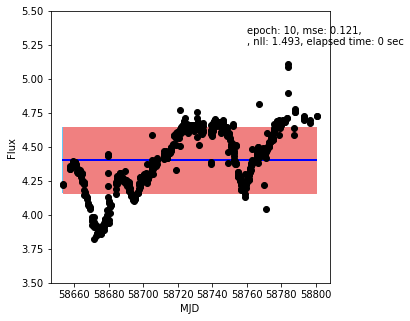

In [29]:
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)
def animate(i):
    x = denorm_recons[i][:,0]
    y = denorm_recons[i][:,1]
    yerr = denorm_recons[i][:,2]

    ax.clear()
    w=2.0
    ax.fill_between(x, y - yerr, y+yerr, color='lightcoral', zorder=30)
    ax.plot(x, y, c='b', lw=w, label='Reconstructions', zorder=40)
    ax.scatter(ex[:,0], ex[:,1], c='black', zorder=50)
    ax.errorbar(x, y ,yerr=yerr,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')
    ax.text(58760, 5.25, f'epoch: {epochs[i]}, mse: {mses[i]}, \n, nll: {nlls[i]}, elapsed time: {elapsed[i]} sec', fontsize=10)
    #ax.set_xlim([0,1])
    ax.set_ylim([3.5,5.5])
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
    

ani = FuncAnimation(fig, animate, frames=100, interval=100, repeat=False)

In [30]:
ani

In [11]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, num_points=40, device="cuda", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        # if torch.is_tensor(example):
        #     example = example.cpu().numpy()
        example = torch.tensor(example)
        # make new masks relative to fraction of points we got to predict w/ 
        subsampled_mask, recon_mask = my_utils.make_masks(example, frac=frac)
        #example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        example = torch.cat((example, torch.unsqueeze(subsampled_mask, 2), torch.unsqueeze(recon_mask, 2), torch.tensor(target_x)), axis=-1)

        #example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:num_points,0]
        px_std = np.mean(px_std, axis=0)[0,:num_points,0]
        target_x = target_x[0,:num_points,0]
        w=2.0
        #plt.figure(figsize=(30, 10))
        #plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        # plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        # plt.scatter(example[0,:,0], example[0,:,1])
        # plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        #plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        #print(f'qz shape: {qz_mean.shape}')
        #print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std

